# Naive Bayes(Scikit-learn)

# 0 Importações 

In [23]:
import glob
import time
import cv2
import os
import numpy as np
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, log_loss,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers


SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Configurações 

In [8]:
image_width = 64
image_height = 64
image_size = (image_width, image_height)
datasets= './datasets/Plastic_Classification/'

In [12]:
# Definir caminhos
dataset = "./datasets/Plastic_Classification"
pasta_train = os.path.join(dataset, "train")
pasta_val = os.path.join(dataset, "validation")
pasta_test = os.path.join(dataset, "test")

# 2 função de carregamento

In [15]:
def carregar_imagens(pasta):
    X, y = [], []
    for classe in sorted(os.listdir(pasta)):
        caminho_classe = os.path.join(pasta, classe)
        if not os.path.isdir(caminho_classe):
            continue
        for arquivo in glob.glob(os.path.join(caminho_classe, "*.jpg")):
            img = cv2.imread(arquivo, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            X.append(img.flatten())
            y.append(classe)
    return np.array(X) / 255.0, np.array(y)




# 3 Pré-Processamento

In [16]:
X_train, y_train = carregar_imagens(pasta_train)
X_val, y_val = carregar_imagens(pasta_val)
X_test, y_test = carregar_imagens(pasta_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)
class_names = le.classes_

# 4 Treinamento

In [17]:
model = GaussianNB()

start_train = time.time()
model.fit(X_train, y_train_enc)
train_time = time.time() - start_train

# 5 Avaliação

In [18]:
start_pred = time.time()
y_pred = model.predict(X_test)
inference_time = (time.time() - start_pred) / len(X_test)

# Previsões de probabilidade (para log loss)
y_proba = model.predict_proba(X_test)

# Métricas
acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average='weighted')
loss = log_loss(y_test_enc, y_proba)

print(f"\n🧠 Tempo de treino: {train_time:.2f}s")
print(f"⚡ Tempo de inferência (por imagem): {inference_time*1000:.2f} ms")
print(f"✅ Acurácia: {acc:.4f}")
print(f"🎯 F1-score ponderado: {f1:.4f}")
print(f"📉 Log Loss: {loss:.4f}")
print("\n📋 Classification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))



🧠 Tempo de treino: 0.25s
⚡ Tempo de inferência (por imagem): 0.75 ms
✅ Acurácia: 0.3445
🎯 F1-score ponderado: 0.2912
📉 Log Loss: 23.4552

📋 Classification Report:

              precision    recall  f1-score   support

        HDPE       0.14      0.03      0.05        30
        LDPA       0.46      0.57      0.51        30
       Other       0.20      0.07      0.10        30
         PET       0.23      0.24      0.24        29
          PP       0.51      1.00      0.67        30
          PS       0.57      0.13      0.22        30
         PVC       0.19      0.37      0.25        30

    accuracy                           0.34       209
   macro avg       0.33      0.34      0.29       209
weighted avg       0.33      0.34      0.29       209



# 6 Matriz de confusão

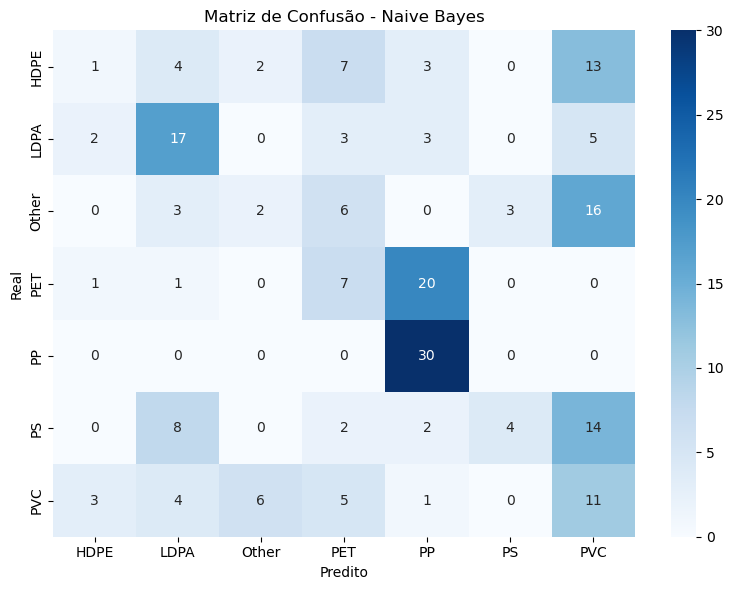

In [19]:
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusão - Naive Bayes")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 7 Previsão e decodificação dos rótulos

In [21]:
# 🔮 Prever com o modelo Naive Bayes
y_pred_nb = model.predict(X_test)

# 🔁 Decodificar os rótulos preditos
y_pred_labels_nb = le.inverse_transform(y_pred_nb)

# ✅ Decodificar os rótulos reais
y_true_labels_nb = le.inverse_transform(y_test_enc)

# 📋 Mostrar as primeiras 10 previsões
for i in range(10):
    print(f"Imagem {i+1}: Real = {y_true_labels_nb[i]} | Predito = {y_pred_labels_nb[i]}")

Imagem 1: Real = HDPE | Predito = PET
Imagem 2: Real = HDPE | Predito = PVC
Imagem 3: Real = HDPE | Predito = PVC
Imagem 4: Real = HDPE | Predito = PVC
Imagem 5: Real = HDPE | Predito = PP
Imagem 6: Real = HDPE | Predito = PP
Imagem 7: Real = HDPE | Predito = HDPE
Imagem 8: Real = HDPE | Predito = PVC
Imagem 9: Real = HDPE | Predito = PVC
Imagem 10: Real = HDPE | Predito = LDPA


# 8 Visualizar imagens com predição

C:\Users\graci.DESKTOP-I7T8UK6\AppData\Local\Temp\ipykernel_5712\3666027629.py:14: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


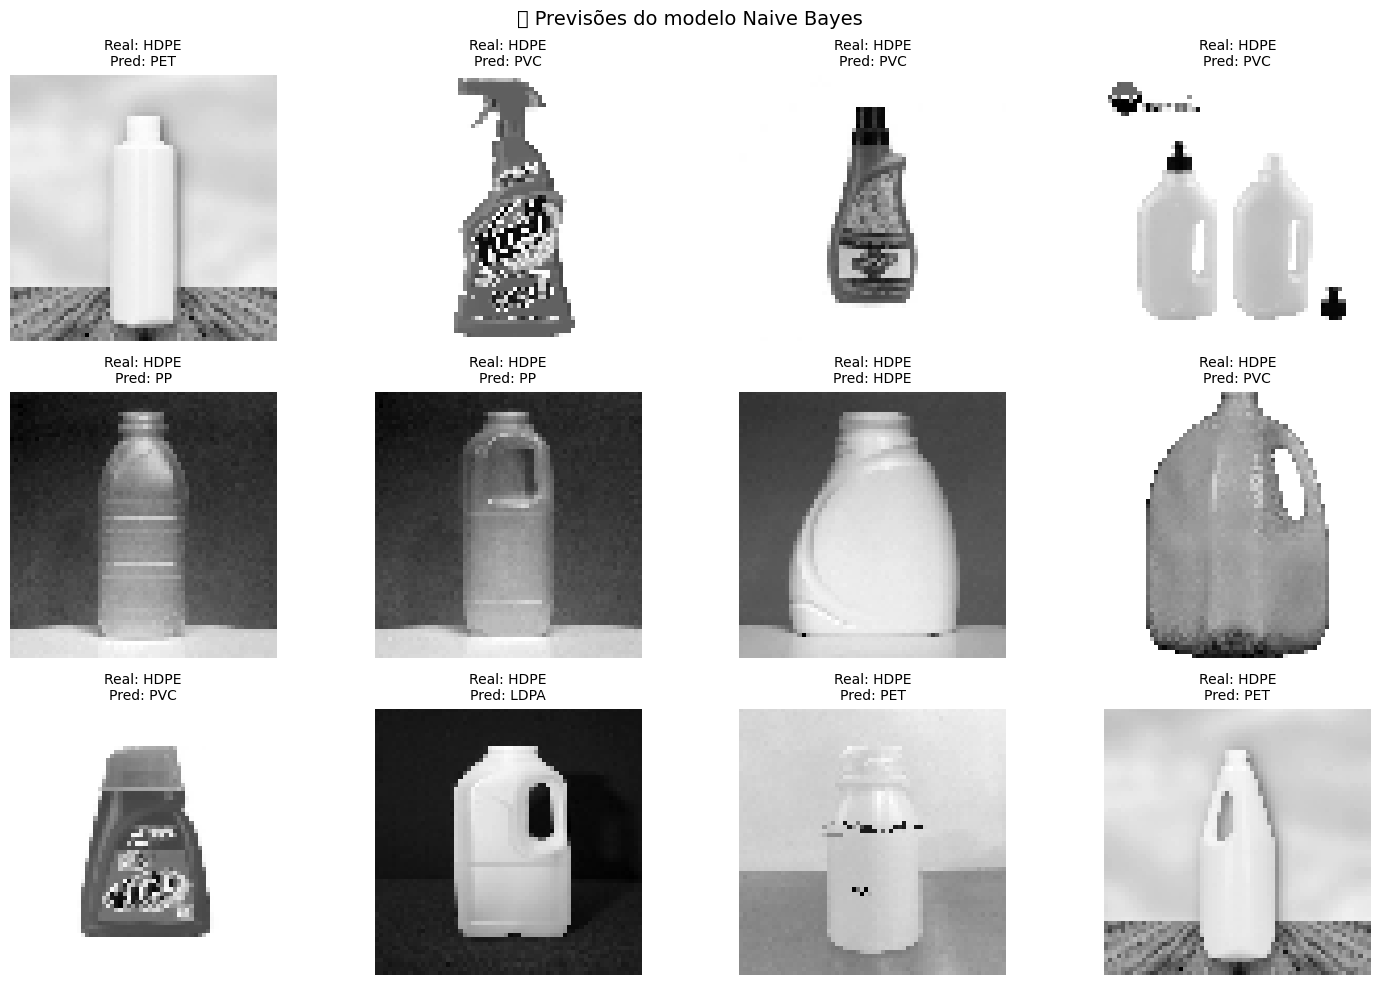

In [22]:
# Recriar imagens a partir de X_test (formato original 64x64)
X_test_imgs = X_test.reshape((-1, 64, 64)) * 255.0  # Reverte normalização

# Mostrar 12 imagens com rótulo real e predito
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test_imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Real: {y_true_labels_nb[i]}\nPred: {y_pred_labels_nb[i]}", fontsize=10)
plt.suptitle("🔍 Previsões do modelo Naive Bayes", fontsize=14)
plt.tight_layout()
plt.show()

# 9 salvar modelo, encoder e métricas:

In [27]:
# Criar pasta se não existir
os.makedirs("models", exist_ok=True)

# Salvar o modelo Naive Bayes
joblib.dump(model, "models/02_naive_bayes/naive_bayes_model.joblib")

# Salvar o LabelEncoder
joblib.dump(le, "models/02_naive_bayes/label_encoder_naive_bayes.joblib")

['models/02_naive_bayes/label_encoder_naive_bayes.joblib']

In [26]:
# Dicionário de métricas
naive_bayes_metrics = {
    "model": "Naive Bayes",
    "accuracy": acc,
    "f1_score_weighted": f1,
    "log_loss": loss,
    "train_time_sec": train_time,
    "inference_time_ms": inference_time * 1000
}

# Salvar as métricas em JSON
with open("models/02_naive_bayes/naive_bayes_metrics.json", "w") as f:
    json.dump(naive_bayes_metrics, f, indent=4)

# Recarregar o modelo e encoder
from sklearn.naive_bayes import GaussianNB
import joblib

model = joblib.load("models/naive_bayes_model.joblib")
le = joblib.load("models/label_encoder.joblib")

# Carregar métricas
with open("models/naive_bayes_metrics.json") as f:
    metrics = json.load(f)
    print(metrics)
